# Proyecto curso Modelos - UdeA 2022-1

## Clasificación de Transacciones Monetarias por Regresión Logística

Se simuló un set de transacciones monetarias que afectan el saldo de cuentas, de tipo Deposito o Fiducia, que pertenecen a unos clientes con identificaciones únicas. Los clientes pueden tener una o varias cuentas. Las transacciones pueden ser de tipo Retiro ó Depósito que en caso de ser llevarse a cabo sin ningun problema se registra el Estado como Exitoso y Causa Ok, con la restricción de no retirar un monto superior al saldo, en dado caso, el estado es Fallido con Causa de Sin_Saldo ó el monto sea cero entonces el estado es Fallido con Causa Monto_Cero. También se simuló, para ambos tipos de transacción, el escenario de sobrepasar un tiempo límite de la transacción, lo cuál genera un Estado Fallido con Causa Timeout.

Usaremos el Clasificador de Regresión Logística para predecir sí una transacción es Exitosa o Fallida

In [ ]:
! pip install pandas-profiling==2.7.1
! pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

In [1]:
from pandas_profiling import ProfileReport
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:.2f}'.format

# Paso 1: Importando la data

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving transacciones.csv to transacciones.csv
User uploaded file "transacciones.csv" with length 163257 bytes


In [3]:
df = pd.read_csv(io.StringIO(uploaded['transacciones.csv'].decode('utf-8')),index_col=0,dayfirst=True,parse_dates=[1])
df

,date_time,client,account,type_account,type_transaction,state_transaction,cause_transaction,amount
id_tran,,,,,,,,
1,2022-07-31 15:20:58.535025,cc15386903,1,DEPOSITOS,RETIRO,EXITOSA,OK,3000
2,2022-08-01 00:09:27.736604,cc15386903,1,DEPOSITOS,RETIRO,EXITOSA,OK,5000
3,2022-08-01 05:13:39.424899,cc15386903,1,DEPOSITOS,RETIRO,EXITOSA,OK,1000
4,2022-08-29 20:11:55.771256,cc15386903,1,DEPOSITOS,RETIRO,EXITOSA,OK,1000
5,2022-09-27 06:47:04.217621,cc15386903,1,DEPOSITOS,RETIRO,EXITOSA,OK,1000
...,...,...,...,...,...,...,...,...
1996,2022-10-20 10:13:00.924928,cc42998185,18,DEPOSITOS,DEPOSITO,FALLIDA,TIMEOUT,286452
1997,2022-10-20 10:13:03.509406,cc42998185,12,FIDUCIA,RETIRO,FALLIDA,SIN_SALDO,360017
1998,2022-10-20 10:13:06.130302,cc32521607,8,DEPOSITOS,DEPOSITO,EXITOSA,OK,187645


# Paso 2: Análisis Previo

In [4]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Paso 3: Set de pruebas y entrenamiento

In [5]:
from sklearn.model_selection import train_test_split


In [6]:
trainingSet, testSet = train_test_split(df, test_size=0.2)

In [7]:
train_df = trainingSet
test_df = testSet

In [178]:
test_df = testSet

In [8]:
train_df

,date_time,client,account,type_account,type_transaction,state_transaction,cause_transaction,amount
id_tran,,,,,,,,
241,2022-10-18 23:24:09.584781,cc43257023,17,DEPOSITOS,DEPOSITO,EXITOSA,OK,62089
1806,2022-10-20 10:04:42.618812,cc1035851920,10,FIDUCIA,RETIRO,EXITOSA,OK,111406
1155,2022-10-18 23:40:29.425321,cc32521607,14,FIDUCIA,RETIRO,EXITOSA,OK,28369
1567,2022-10-20 08:20:04.246509,cc15386903,7,FIDUCIA,DEPOSITO,FALLIDA,MONTO_CERO,0
1061,2022-10-18 23:39:22.811350,cc32521607,2,FIDUCIA,DEPOSITO,FALLIDA,TIMEOUT,77834
...,...,...,...,...,...,...,...,...
600,2022-10-18 23:33:47.729464,cc1035851920,16,DEPOSITOS,RETIRO,FALLIDA,TIMEOUT,75248
256,2022-10-18 23:24:20.286982,ti1020307549,15,DEPOSITOS,RETIRO,EXITOSA,OK,85904
1384,2022-10-18 23:43:05.494241,ti1020307549,15,DEPOSITOS,RETIRO,FALLIDA,TIMEOUT,45390


In [179]:
test_df

,date_time,client,account,type_account,type_transaction,state_transaction,cause_transaction,amount
id_tran,,,,,,,,
1366,2022-10-18 23:42:54.320311,cc43257023,11,FIDUCIA,RETIRO,FALLIDA,TIMEOUT,153031
1994,2022-10-20 10:12:55.756537,cc15386903,1,DEPOSITOS,RETIRO,FALLIDA,SIN_SALDO,199899
1343,2022-10-18 23:42:39.929755,cc1035851920,4,DEPOSITOS,DEPOSITO,FALLIDA,TIMEOUT,17059
825,2022-10-18 23:36:12.416479,cc15386903,7,FIDUCIA,RETIRO,EXITOSA,OK,43446
32,2022-10-18 23:15:35.463441,cc42998185,6,DEPOSITOS,RETIRO,FALLIDA,TIMEOUT,328
...,...,...,...,...,...,...,...,...
1441,2022-10-18 23:43:40.569131,ti1020307549,15,DEPOSITOS,RETIRO,EXITOSA,OK,23532
1749,2022-10-20 09:36:16.025188,cc43257023,11,FIDUCIA,RETIRO,FALLIDA,SIN_SALDO,378935
1116,2022-10-18 23:40:02.054116,cc32521607,8,DEPOSITOS,RETIRO,EXITOSA,OK,17874


# Paso 4: Porcentaje de Estado

In [10]:
estado = train_df['state_transaction'].value_counts()
estado_rate = [estado[0]/len(train_df)*100,estado[1]/len(train_df)*100]
estado

EXITOSA    1061
FALLIDA     539
Name: state_transaction, dtype: int64

In [11]:
estado_rate

[66.3125, 33.6875]

In [12]:
train_df.groupby('state_transaction').mean()

,account,amount
state_transaction,,
EXITOSA,9.77,88459.28
FALLIDA,9.21,120961.50


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'ESTADO / CLIENTE CHART')

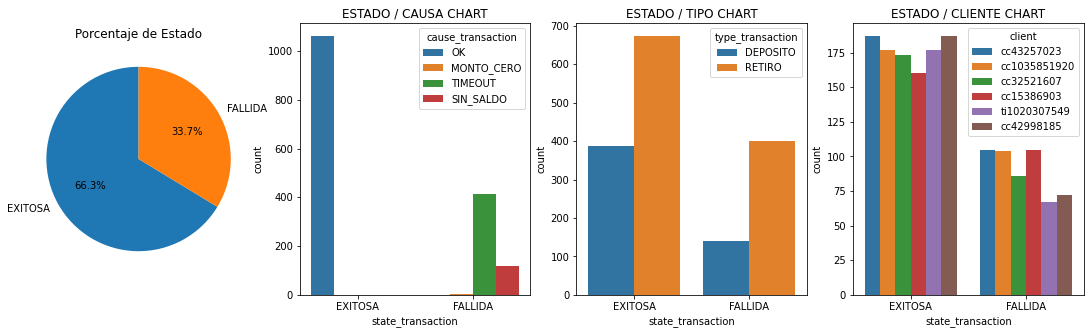

In [13]:
fig,ax = plt.subplots(nrows=1,ncols = 4,figsize = (19,5))
plt.subplot(1,4,1)
plt.pie(estado_rate,labels = ['EXITOSA','FALLIDA'],autopct='%1.1f%%',startangle = 90,)
plt.title('Porcentaje de Estado')
plt.subplot(1,4,2)
sns.countplot('state_transaction',data = train_df,hue = 'cause_transaction')
plt.title('ESTADO / CAUSA CHART')
plt.subplot(1,4,3)
sns.countplot('state_transaction',data = train_df,hue = 'type_transaction')
plt.title('ESTADO / TIPO CHART')
plt.subplot(1,4,4)
sns.countplot('state_transaction',data = train_df,hue = 'client')
plt.title('ESTADO / CLIENTE CHART')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


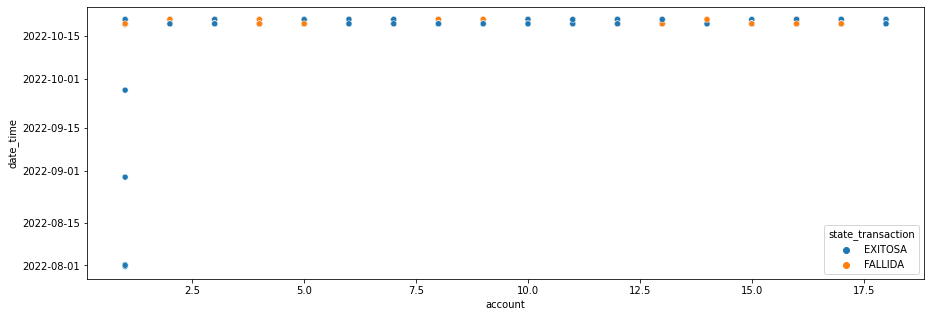

In [14]:
plt.subplots(figsize = (15,5))
sns.scatterplot('account','date_time',data = train_df,hue = 'state_transaction')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

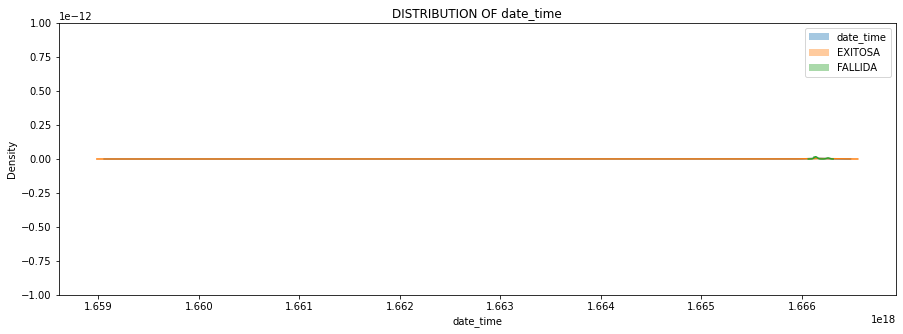

In [15]:
fig,ax = plt.subplots(figsize = (15,5))
sns.distplot(train_df['date_time'],label = 'date_time')
sns.distplot(train_df[train_df['state_transaction'] == 'EXITOSA']['date_time'],label = 'EXITOSA')
sns.distplot(train_df[train_df['state_transaction'] == 'FALLIDA']['date_time'],label = 'FALLIDA')
plt.title('DISTRIBUTION OF date_time')
plt.legend()
plt.show()

# Paso 5: Convirtiendo campos categoricos a valores númericos

In [17]:
le = LabelEncoder()
train_df['client'] = le.fit_transform(train_df['client'])
train_df['type_account'] = le.fit_transform(train_df['type_account'])
train_df['type_transaction'] = le.fit_transform(train_df['type_transaction'])
train_df['state_transaction'] = le.fit_transform(train_df['state_transaction'])
train_df['cause_transaction'] = le.fit_transform(train_df['cause_transaction'])




In [18]:
train_df

,date_time,client,account,type_account,type_transaction,state_transaction,cause_transaction,amount
id_tran,,,,,,,,
241,2022-10-18 23:24:09.584781,4,17,0,0,0,1,62089
1806,2022-10-20 10:04:42.618812,0,10,1,1,0,1,111406
1155,2022-10-18 23:40:29.425321,2,14,1,1,0,1,28369
1567,2022-10-20 08:20:04.246509,1,7,1,0,1,0,0
1061,2022-10-18 23:39:22.811350,2,2,1,0,1,3,77834
...,...,...,...,...,...,...,...,...
600,2022-10-18 23:33:47.729464,0,16,0,1,1,3,75248
256,2022-10-18 23:24:20.286982,5,15,0,1,0,1,85904
1384,2022-10-18 23:43:05.494241,5,15,0,1,1,3,45390


## Seleccionando Features

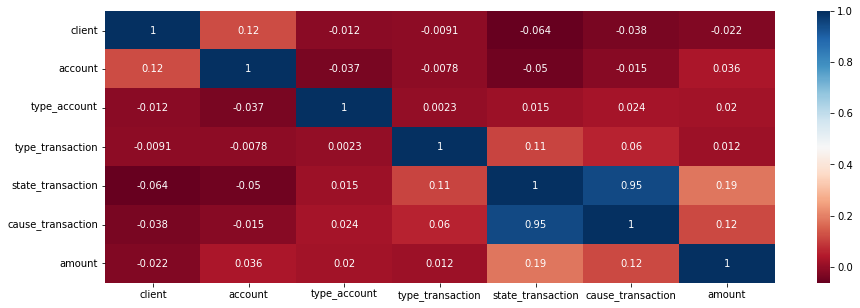

In [19]:
plt.subplots(figsize = (15,5))
sns.heatmap(train_df.corr(),cmap = 'RdBu',cbar = True,annot = True)

In [20]:
train_df = train_df.drop(columns = ['date_time','cause_transaction'])
train_df = train_df.reindex(columns=['state_transaction','client','account','type_account','type_transaction','amount'])
train_df

,state_transaction,client,account,type_account,type_transaction,amount
id_tran,,,,,,
241,0,4,17,0,0,62089
1806,0,0,10,1,1,111406
1155,0,2,14,1,1,28369
1567,1,1,7,1,0,0
1061,1,2,2,1,0,77834
...,...,...,...,...,...,...
600,1,0,16,0,1,75248
256,0,5,15,0,1,85904
1384,1,5,15,0,1,45390


In [21]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [22]:
features = train_df.iloc[:,1:]
target = train_df.iloc[:,0]

In [23]:
best_features = SelectKBest(score_func = chi2,k = 5)
fit = best_features.fit(features,target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Column','Score'] 
print(featureScores.nlargest(5,'Score'))

             Column      Score
4            amount 3798279.27
1           account      11.64
0            client       7.62
3  type_transaction       6.19
2      type_account       0.21


In [24]:
train_df = train_df.drop(columns = ['type_account','type_transaction','client'])
train_df

,state_transaction,account,amount
id_tran,,,
241,0,17,62089
1806,0,10,111406
1155,0,14,28369
1567,1,7,0
1061,1,2,77834
...,...,...,...
600,1,16,75248
256,0,15,85904
1384,1,15,45390


In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
features = train_df[['account','amount']].values
features = sc.fit_transform(features)
target = train_df['state_transaction'].values

In [26]:
features

array([[ 1.39178308, -0.44948944],
       [ 0.0784483 ,  0.14450272],
       [ 0.82892532, -0.85562556],
       ...,
       [ 1.01654457, -0.65061836],
       [-0.48440946, -0.58665071],
       [ 1.57940233,  0.75959661]])

In [27]:
target

array([0, 0, 0, ..., 1, 0, 0])

# Modelos

In [28]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.25, random_state = 2)

acompañar la media con el cálculo de la desv std

In [164]:
def model(classifier):
    
    classifier.fit(x_train,y_train)
    prediction = classifier.predict(x_test)
    print("ACCURACY : ",'{0:.2%}'.format(accuracy_score(y_test,prediction)))  
    print("CROSS VALIDATION SCORE : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = 10,scoring = 'accuracy').mean()))
    # print("CROSS VALIDATION SCORE : ",'{0:.2%}'.format(cross_val_score(classifier,x_train,y_train,cv = 12,scoring = 'accuracy').std()))
    print("ROC_AUC SCORE : ",'{0:.2%}'.format(roc_auc_score(y_test,prediction)))
    plot_roc_curve(classifier, x_test,y_test)
    plt.title('ROC_AUC_PLOT')
    plt.show()

In [165]:
def model_evaluation(classifier):
    
    # CONFUSION MATRIX
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    tn,fp,fn,tp = cm.flatten()
    
    # PRECISION
    print('PRECISION : ','{0:.2%}'.format(tp/(tp + fp)))
    
    # RECALL
    print('RECALL : ','{0:.2%}'.format(tp/(tp + fn)))

In [166]:
def grid_search_cv(classifier,hyperparameters):
    
    GSCV = GridSearchCV(classifier,hyperparameters,cv = 10)
    model = GSCV.fit(x_test,y_test)
    print(model)
    print('HIGHEST ACCURACY : ','{0:.2%}'.format(model.best_score_))
    print('BEST PARAMETERS : ',model.best_params_)

# REGRESIÓN LOGÍSTICA


#### Sigmoid  / Logistic Function

$p =1 / 1 + e^{-y}$

### ROC (Receiver Operation Characteristic) Curve
Plotting true positive rate against false positie rate. Shows tradeoff between sensitivity and specificity. 

### What is AUC - ROC Curve? (credit https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)
#### AUC - ROC curve 
Is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, Higher the AUC, better the model is at distinguishing between patients with disease and no disease.

* The ROC curve is plotted with TPR against the FPR where TPR is on y-axis and FPR is on the x-axis.

In [167]:
from sklearn.linear_model import LogisticRegression

In [168]:
classifier_lr = LogisticRegression(random_state = 0,C=10,penalty= 'l2',solver='lbfgs')

revisar parámetro SOLVER e ir probando, cambiar parámetro C para determinar el sobreajuste

comparar accuracy training model vs test model

ACCURACY :  66.50%
CROSS VALIDATION SCORE :  68.67%
ROC_AUC SCORE :  52.51%


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


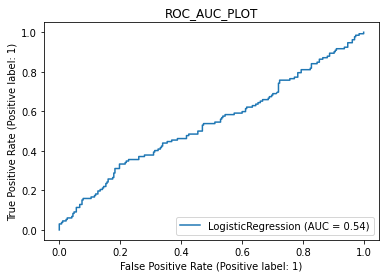

In [169]:
model(classifier_lr)

problema con el modelo: debe estar más a izq - ajuste parámetros del modelo

PRECISION :  46.88%
RECALL :  11.36%


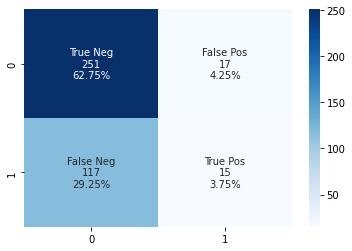

In [170]:
model_evaluation(classifier_lr)

In [171]:
train_df

,state_transaction,account,amount
id_tran,,,
241,0,17,62089
1806,0,10,111406
1155,0,14,28369
1567,1,7,0
1061,1,2,77834
...,...,...,...
600,1,16,75248
256,0,15,85904
1384,1,15,45390


# PREDICTION ON TEST DATASET

In [172]:
test_tocompare = test_df
test_tocompare

,date_time,client,account,type_account,type_transaction,state_transaction,cause_transaction,amount
id_tran,,,,,,,,
1366,2022-10-18 23:42:54.320311,cc43257023,11,FIDUCIA,RETIRO,FALLIDA,TIMEOUT,153031
1994,2022-10-20 10:12:55.756537,cc15386903,1,DEPOSITOS,RETIRO,FALLIDA,SIN_SALDO,199899
1343,2022-10-18 23:42:39.929755,cc1035851920,4,DEPOSITOS,DEPOSITO,FALLIDA,TIMEOUT,17059
825,2022-10-18 23:36:12.416479,cc15386903,7,FIDUCIA,RETIRO,EXITOSA,OK,43446
32,2022-10-18 23:15:35.463441,cc42998185,6,DEPOSITOS,RETIRO,FALLIDA,TIMEOUT,328
...,...,...,...,...,...,...,...,...
1441,2022-10-18 23:43:40.569131,ti1020307549,15,DEPOSITOS,RETIRO,EXITOSA,OK,23532
1749,2022-10-20 09:36:16.025188,cc43257023,11,FIDUCIA,RETIRO,FALLIDA,SIN_SALDO,378935
1116,2022-10-18 23:40:02.054116,cc32521607,8,DEPOSITOS,RETIRO,EXITOSA,OK,17874


## PREPROCEANDO EN TEST DATASET

In [180]:
client_id = test_df['client']
account_id = test_df['account']
amount = test_df['amount']
tacount = test_df['type_account']
ttransaction = test_df['type_transaction']
test_df = test_df.drop(columns = ['date_time','client','type_account','type_transaction','state_transaction','cause_transaction'])
test_df

,account,amount
id_tran,,
1366,11,153031
1994,1,199899
1343,4,17059
825,7,43446
32,6,328
...,...,...
1441,15,23532
1749,11,378935
1116,8,17874


In [181]:
test_df = sc.fit_transform(test_df)

In [182]:
test_df

array([[ 0.37968782,  0.5867964 ],
       [-1.5525657 ,  1.1296797 ],
       [-0.97288964, -0.98819992],
       [-0.39321359, -0.68255296],
       [-0.58643894, -1.18199911],
       [-1.5525657 , -1.01964841],
       [ 1.15258922,  1.10900361],
       [ 1.15258922,  0.04016014],
       [-1.166115  ,  0.30372518],
       [-0.58643894, -0.49481181],
       [ 0.76613852, -0.72534145],
       [ 0.37968782,  0.38127497],
       [ 1.15258922, -1.04991542],
       [ 0.95936387, -0.1023253 ],
       [-0.77966429, -0.66923224],
       [ 0.18646246, -0.36611043],
       [-1.35934035, -0.11703602],
       [-0.39321359, -0.80642413],
       [-0.97288964,  0.0587049 ],
       [-0.58643894,  1.01236464],
       [-0.77966429,  2.7232787 ],
       [ 1.34581457,  0.32955581],
       [ 0.57291317,  3.22531949],
       [-0.97288964, -0.86575349],
       [-0.39321359,  0.75643295],
       [ 1.15258922,  0.6286814 ],
       [ 0.76613852,  1.88693402],
       [-0.00676289, -0.70310163],
       [-0.00676289,

In [183]:
prediction = classifier_lr.predict(test_df)
submission = pd.DataFrame({'client':client_id, 'account':account_id, 'amount':amount, 'state_transaction':prediction})
submission

,client,account,amount,state_transaction
id_tran,,,,
1366,cc43257023,11,153031,0
1994,cc15386903,1,199899,1
1343,cc1035851920,4,17059,0
825,cc15386903,7,43446,0
32,cc42998185,6,328,0
...,...,...,...,...
1441,ti1020307549,15,23532,0
1749,cc43257023,11,378935,1
1116,cc32521607,8,17874,0


In [185]:
estado_submission = submission['state_transaction'].value_counts()
submission_rate = [estado_submission[0]/len(submission)*100,estado_submission[1]/len(submission)*100]
estado_submission


0    370
1     30
Name: state_transaction, dtype: int64

In [186]:
test_tocompare = test_tocompare.drop(columns = ['date_time','type_account','type_transaction','cause_transaction'])
test_tocompare

,client,account,state_transaction,amount
id_tran,,,,
1366,cc43257023,11,FALLIDA,153031
1994,cc15386903,1,FALLIDA,199899
1343,cc1035851920,4,FALLIDA,17059
825,cc15386903,7,EXITOSA,43446
32,cc42998185,6,FALLIDA,328
...,...,...,...,...
1441,ti1020307549,15,EXITOSA,23532
1749,cc43257023,11,FALLIDA,378935
1116,cc32521607,8,EXITOSA,17874


In [187]:
test_tocompare['state_transaction'] = le.fit_transform(test_tocompare['state_transaction'])
test_tocompare = test_tocompare.reindex(columns=['client','account','amount','state_transaction'])
test_tocompare


,client,account,amount,state_transaction
id_tran,,,,
1366,cc43257023,11,153031,1
1994,cc15386903,1,199899,1
1343,cc1035851920,4,17059,1
825,cc15386903,7,43446,0
32,cc42998185,6,328,1
...,...,...,...,...
1441,ti1020307549,15,23532,0
1749,cc43257023,11,378935,1
1116,cc32521607,8,17874,0


In [188]:
test_tocompare.compare(submission,keep_shape=False, keep_equal=True)

state_transaction      
                     self other
id_tran                        
1366                    1     0
1343                    1     0
32                      1     0
425                     1     0
399                     1     0
...                   ...   ...
41                      1     0
1671                    1     0
1115                    1     0
598                     1     0
1266                    1     0

[112 rows x 2 columns]